# Apple price prediction

In [1]:
# Regression models
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.tree import DecisionTreeRegressor

# Model slection
from sklearn.model_selection import train_test_split

# Preprocessing
from sklearn.preprocessing import StandardScaler

# Metrics
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn import metrics

# Visualisations
import missingno
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Other
from scipy import stats
import math
import pickle
import pandas as pd
import numpy as np

In [2]:
# increasing row visability 
pd.set_option('display.max_rows', 65)

In [3]:
#Loading data
test_set = 'df-test_set.csv'
train_set = 'df-train_set.csv'
train = pd.read_csv(train_set)
test = pd.read_csv(test_set)

In [4]:
#Spliting up index column for exporting
index = test['Index']
test = test.drop('Index',axis=1)

### Brief data overview

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64376 entries, 0 to 64375
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Province          64376 non-null  object 
 1   Container         64376 non-null  object 
 2   Size_Grade        64376 non-null  object 
 3   Weight_Kg         64376 non-null  float64
 4   Commodities       64376 non-null  object 
 5   Date              64376 non-null  object 
 6   Low_Price         64376 non-null  float64
 7   High_Price        64376 non-null  float64
 8   Sales_Total       64376 non-null  float64
 9   Total_Qty_Sold    64376 non-null  int64  
 10  Total_Kg_Sold     64376 non-null  float64
 11  Stock_On_Hand     64376 non-null  int64  
 12  avg_price_per_kg  64376 non-null  float64
dtypes: float64(6), int64(2), object(5)
memory usage: 6.4+ MB


In [6]:
# K date is an object, will have to look into that.

In [7]:
train.describe()

,Weight_Kg,Low_Price,High_Price,Sales_Total,Total_Qty_Sold,Total_Kg_Sold,Stock_On_Hand,avg_price_per_kg
count,64376.000000,64376.000000,64376.000000,6.437600e+04,64376.000000,64376.000000,64376.000000,64376.00
mean,12.781592,75.651938,89.607858,1.939501e+04,446.104402,3336.641295,477.646328,NaN
std,35.943052,159.508144,172.223177,4.442192e+04,1184.169758,7682.295441,1453.892091,NaN
min,0.120000,1.000000,1.000000,-5.770000e+04,-595.000000,-5040.000000,-512.000000,-inf
25%,7.000000,30.000000,35.000000,1.154000e+03,20.000000,175.000000,0.000000,4.02
50%,10.000000,46.000000,55.000000,5.400000e+03,107.000000,940.000000,76.000000,6.00
75%,11.000000,80.000000,100.000000,1.877200e+04,390.000000,3250.000000,381.000000,8.67
max,500.000000,4400.000000,4400.000000,1.134701e+06,39453.000000,192230.000000,93193.000000,inf


In [8]:
#Remove 'inf' and look into negative values

In [9]:
# Just having a look at how many rows values are negative
Stock_On_Hand_neg = train[train['Stock_On_Hand'] < 0]
Total_Kg_Sold_neg = train[train['Total_Kg_Sold'] < 0]
Total_Qty_Sold_neg = train[train['Total_Qty_Sold'] < 0]
Sales_Total_neg = train[train['Sales_Total'] < 0]

In [10]:
Stock_On_Hand_neg.shape


(67, 13)

In [11]:
Total_Kg_Sold_neg.shape

(32, 13)

In [12]:
Total_Qty_Sold_neg.shape

(32, 13)

In [13]:
Sales_Total_neg.shape

(43, 13)

Ok all the negative values only amount to a very small part of the data

In [14]:
#Checkcing for null values
train.isnull().sum()

Province            0
Container           0
Size_Grade          0
Weight_Kg           0
Commodities         0
Date                0
Low_Price           0
High_Price          0
Sales_Total         0
Total_Qty_Sold      0
Total_Kg_Sold       0
Stock_On_Hand       0
avg_price_per_kg    0
dtype: int64

# Lets clean this up a bit.

In [15]:
#Convert Date from object to datetime64[ns] 
train["Date"] = pd.to_datetime(train["Date"])
#Extracting month from datetime
train['Date'] = pd.DatetimeIndex(train['Date']).month

In [16]:
# Changing dates from months to seasons
month_list = train['Date'].tolist()

summer = (12,1,2)
autumn = (3,4,5)
winter = (6,7,8)
spring = (9,10,11)
season_list = []

for i in month_list:
    if i in summer:
        season_list.append('summer')
    elif i in autumn:
        season_list.append('autumn')
    elif i in winter:
        season_list.append('winter')
    else:
        season_list.append('spring')

train['Date'] = train['Date'].astype(str)
train['Date'] = season_list

In [17]:
# Province's
# Train

province_list = train['Province'].unique()
western_cape = ('CAPE', 'W.CAPE-BERGRIVER ETC','WEST COAST','WESTERN CAPE - CERES','SOUTHERN CAPE')
eastern_cape = ('NORTH EASTERN CAPE', 'EASTERN CAPE')
freestate = ('WESTERN FREESTATE','SOUTH WESTERN FREE STATE','EASTERN FREESTATE')
gauteng = ('GAUTENG','NORTH WEST')
transvaal = ('TRANSVAAL','ORANGE FREE STATE')
natal = ('NATAL','KWAZULU NATAL')
mpumalanga = ('MPUMALANGA','MPUMALANGA MIDVELD')
other = ('IMPORTS - OUTSIDE RSA', 'OTHER AREAS','NAMIBIA')

province_list = []

for i in train['Province']:
    if i in western_cape:
        province_list.append('western cape')
    elif i in eastern_cape:
        province_list.append('eastern cape')
    elif i in freestate:
        province_list.append('freestate')
    elif i in gauteng:
        province_list.append('gauteng')
    elif i in transvaal:
        province_list.append('transvaal')
    elif i in natal:
        province_list.append('natal')
    elif i in mpumalanga:
        province_list.append('mpumalanga')
    elif i in other:
        province_list.append('other')
    else:
        province_list.append(i)

train['Province'] = province_list

In [18]:
#Replacing infintes with NaN
train.replace([np.inf, -np.inf], np.nan, inplace=True)

In [19]:
# Droping nan's
train = train.dropna()

In [20]:
train.shape

(64368, 13)

In [21]:
# Negatives be gone
def negitive_where(df,column):
    listo = df[column].tolist()
    up_dated_listo = []
    for i in listo:
        if i < 0:
            up_dated_listo.append(abs(i))
        else:
            up_dated_listo.append(i)
    
    df[column] = up_dated_listo
    
    return df

In [22]:
negitive_where(train,'avg_price_per_kg').shape
negitive_where(train,'Stock_On_Hand').shape
negitive_where(train,'Total_Kg_Sold').shape
negitive_where(train,'Total_Qty_Sold').shape
negitive_where(train,'Sales_Total').shape

(64368, 13)

## Checking for Multicollinearity

### Pairwise

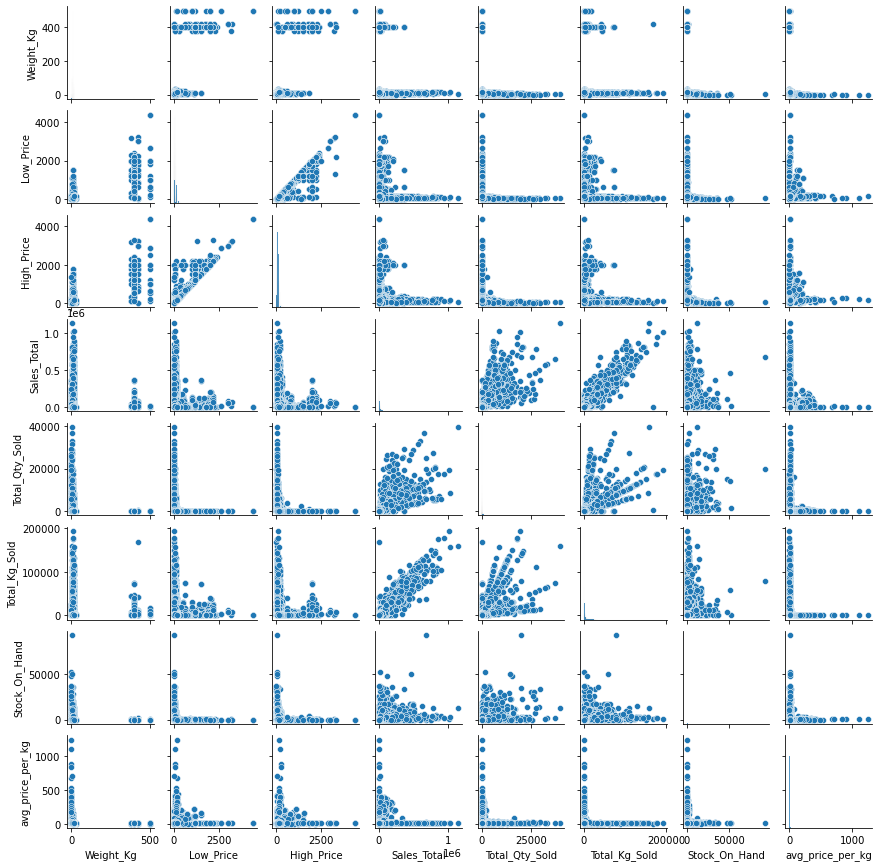

In [23]:
# Due to the number of visuals created, this codeblock takes about one minute to run.
from seaborn import pairplot
g = pairplot(train)
g.fig.set_size_inches(12,12)

### Correlation heatmap

<AxesSubplot:>

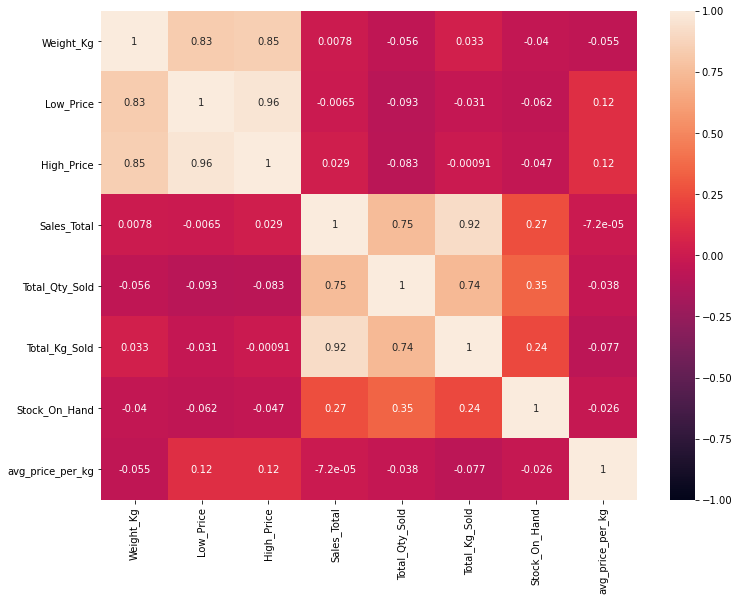

In [24]:
#Correlations
plt_size = (12, 9)
fig, ax = plt.subplots(figsize=plt_size)
sns.heatmap(train.corr(), vmin=-1, vmax=1,annot=True)

There apears to be some strong correlation between some of the independent variable's.

In [25]:
# Droping these columns because they have low correlation with the DV and too high corr with each other
train = train.drop(['Low_Price','High_Price','Total_Kg_Sold'],axis=1) # Total_Kg_Sold - will be 0.32736
test = test.drop(['Low_Price','High_Price','Total_Kg_Sold'],axis=1) # Sales_Total

C:\Users\Matthew\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='avg_price_per_kg', ylabel='Density'>

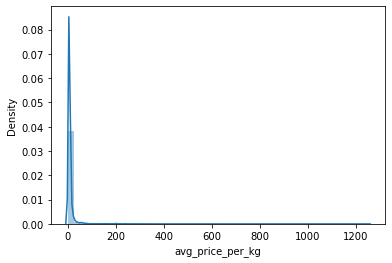

In [26]:
# Distribution
sns.distplot(train['avg_price_per_kg'],kde=True)

In [27]:
# Appears to be some outliers

In [28]:
train.shape

(64368, 10)

In [29]:
#Distribution tuning
train = train[train['avg_price_per_kg'] < 15] # 15
train = train[train['avg_price_per_kg'] > 1]  # 1

C:\Users\Matthew\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='avg_price_per_kg', ylabel='Density'>

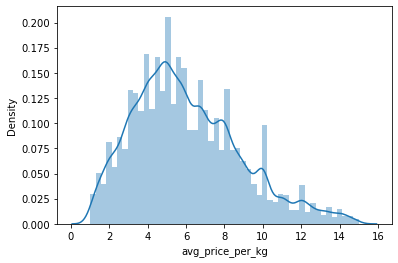

In [30]:
sns.distplot(train['avg_price_per_kg'],kde=True)

In [31]:
train.shape

(56890, 10)

In [32]:
train.describe()

,Weight_Kg,Sales_Total,Total_Qty_Sold,Stock_On_Hand,avg_price_per_kg
count,56890.000000,5.689000e+04,56890.000000,56890.000000,56890.000000
mean,13.590030,2.028745e+04,471.905555,496.276815,6.048653
std,37.244198,4.601707e+04,1199.798631,1473.568026,2.791762
min,0.500000,5.000000e+00,1.000000,0.000000,1.010000
25%,7.000000,1.280000e+03,23.000000,0.000000,4.000000
50%,10.000000,5.880000e+03,111.000000,82.000000,5.590000
75%,12.000000,1.972875e+04,437.000000,414.000000,7.790000
max,500.000000,1.134701e+06,39453.000000,93193.000000,14.990000


In [33]:
train.corr()

,Weight_Kg,Sales_Total,Total_Qty_Sold,Stock_On_Hand,avg_price_per_kg
Weight_Kg,1.000000,0.006618,-0.061504,-0.042981,-0.066114
Sales_Total,0.006618,1.000000,0.758003,0.265085,0.064113
Total_Qty_Sold,-0.061504,0.758003,1.000000,0.329285,0.011245
Stock_On_Hand,-0.042981,0.265085,0.329285,1.000000,0.023243
avg_price_per_kg,-0.066114,0.064113,0.011245,0.023243,1.000000


In [34]:
# Pruning a few more columns 
train = train.drop(['Container','Commodities','Size_Grade','Province','Stock_On_Hand','Date'],axis=1)  #  , 
test = test.drop(['Container','Commodities','Size_Grade','Province','Stock_On_Hand','Date'],axis=1) # Total_Qty_Sold ,

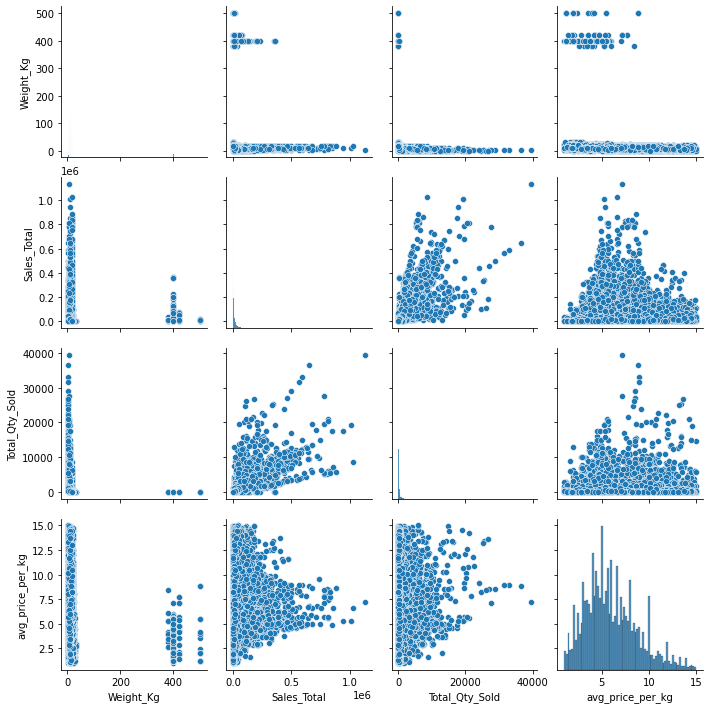

In [35]:
# Corr
sns.pairplot(train)
plt.show()

## Feature Engineering

### Dummy Variable

In [36]:
# Creating dummy variables for the categorical data
train_dummies = pd.get_dummies(train, drop_first=True)

# Changing column names to prevent errors
train_dummies.columns = [col.replace(" ","_") for col in train_dummies.columns]
train_dummies.columns = [col.replace(")","_") for col in train_dummies.columns]
train_dummies.columns = [col.replace("(","_") for col in train_dummies.columns]
train_dummies.columns = [col.replace("-","_") for col in train_dummies.columns]
train_dummies.columns = [col.replace(".","_") for col in train_dummies.columns]
train_dummies.columns = [col.replace("/","_") for col in train_dummies.columns]

In [37]:
train = train_dummies

In [38]:
train_dummies.shape

(56890, 4)

## Separating y from X variables

In [39]:
# split predictors and response
y = train['avg_price_per_kg']
X = train.drop(['avg_price_per_kg'], axis=1)

## Data overview the model using statsmodels.OLS

In [40]:
from statsmodels.formula.api import ols

# Model DataFrame with all of the columns:
dfm = train.copy()

# The dependent variable:
y_name = 'avg_price_per_kg'
# The independent variable
# (let's first try all of the columns in the model DataFrame)
X_names = [col for col in dfm.columns if col != y_name]

# Build the OLS formula string " y ~ X "
formula_str = y_name+" ~ "+" + ".join(X_names);
print('Formula:\n\t {}'.format(formula_str))

Formula:
	 avg_price_per_kg ~ Weight_Kg + Sales_Total + Total_Qty_Sold


In [41]:
# Fit the model using the model dataframe
model=ols(formula=formula_str, data=dfm)
fitted = model.fit()

# Output the fitted summary
print(fitted.summary())

                            OLS Regression Results                            
Dep. Variable:       avg_price_per_kg   R-squared:                       0.013
Model:                            OLS   Adj. R-squared:                  0.013
Method:                 Least Squares   F-statistic:                     243.6
Date:                Tue, 18 May 2021   Prob (F-statistic):          4.47e-157
Time:                        10:43:02   Log-Likelihood:            -1.3877e+05
No. Observations:               56890   AIC:                         2.775e+05
Df Residuals:                   56886   BIC:                         2.776e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          6.0600      0.013    449.

In [42]:
# Calculate correlations between predictor variables and the response variable
corrs = train.corr()['avg_price_per_kg'].sort_values(ascending=False)

In [43]:
from scipy.stats import pearsonr

# Build a dictionary of correlation coefficients and p-values
dict_cp = {}

column_titles = [col for col in corrs.index if col!= 'avg_price_per_kg']
for col in X:
    p_val = round(pearsonr(X[col], y)[1],6)
    dict_cp[col] = {'Correlation_Coefficient':corrs[col],
                    'P_Value':p_val}
    
df_cp = pd.DataFrame(dict_cp).T
df_cp_sorted = df_cp.sort_values('P_Value')
df_cp_sorted[df_cp_sorted['P_Value'] <=0.05]

,Correlation_Coefficient,P_Value
Weight_Kg,-0.066114,0.000000
Sales_Total,0.064113,0.000000
Total_Qty_Sold,0.011245,0.007313


In [44]:
# List of columns where p value is statistically significant
p = df_cp_sorted[df_cp_sorted['P_Value'] < 0.05]
p = p.index

In [45]:
p

Index(['Weight_Kg', 'Sales_Total', 'Total_Qty_Sold'], dtype='object')

In [46]:
len(p)

3

In [47]:
X.shape

(56890, 3)

In [48]:
# Modifing X data
# Removing all columns with a p_value greater then 0.05
for i in X:
    if i in p:
        pass
    else:
        X = X.drop(i,axis=1)

In [49]:
# Droping a few dimensions
X.shape

(56890, 3)

### Prepping Test Data

In [50]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 685 entries, 0 to 684
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Weight_Kg       685 non-null    float64
 1   Sales_Total     685 non-null    float64
 2   Total_Qty_Sold  685 non-null    int64  
dtypes: float64(2), int64(1)
memory usage: 16.2 KB


In [51]:
# #Convert Date from object to datetime64[ns] 
# test["Date"] = pd.to_datetime(test["Date"])
# #Extracting month from datetime and changing type to int
# test['Date'] = pd.DatetimeIndex(test['Date']).month

In [52]:
# Month to seasons

# month_list = test['Date'].tolist()
# season_list = []

# for i in month_list:
#     if i in summer:
#         season_list.append('summer')
#     elif i in autumn:
#         season_list.append('autumn')
#     elif i in winter:
#         season_list.append('winter')
#     else:
#         season_list.append('spring')

# test['Date'] = test['Date'].astype(str)
# test['Date'] = season_list

In [53]:
# To be removed if not going to use Province column

# Province's

# province_list_test = []

# for i in test['Province']:
#     if i in western_cape:
#         province_list_test.append('western_cape')
#     elif i in eastern_cape:
#         province_list_test.append('eastern_cape')
#     elif i in freestate:
#         province_list_test.append('freestate')
#     elif i in gauteng:
#         province_list_test.append('gauteng')
#     elif i in transvaal:
#         province_list_test.append('transvaal')
#     elif i in natal:
#         province_list_test.append('natal')
#     elif i in mpumalanga:
#         province_list_test.append('mpumalanga')
#     elif i in other:
#         province_list_test.append('other')
#     else:
#         province_list_test.append(i)

# test['Province'] = province_list_test

In [54]:
# Creating dummy variables for the categorical data
test_dummies = pd.get_dummies(test, drop_first=True)

# Column name white space replacement
test_dummies.columns = [col.replace(" ","_") for col in test_dummies.columns]

In [55]:
test = test_dummies

In [56]:
test.shape

(685, 3)

In [57]:
# If there is a dimensions mismatch in test to training data

In [58]:
# List of columns names
test_list = test.columns.unique()

In [59]:
# Modifing X data
# Removing columns that are not in the test data

for i in X:
    if i in test_list:
        pass
    else:
        X = X.drop(i,axis=1)

In [60]:
X.shape

(56890, 3)

In [61]:
test.shape

(685, 3)

In [62]:
# Pruning test dimensions
# Removing columns that do not apear in train data
X_dimensions = X.columns.tolist()

for i in test:
    if i in X_dimensions:
        pass
    else:
        test = test.drop(i,axis=1)

In [63]:
test.shape

(685, 3)

## Implementing Scaling
Creating Standardize versions of X and y aswell as test data

In [64]:
# Create scaler object
scaler = StandardScaler()

In [65]:
# Create scaled version of the predictors (there is no need to scale the response)
X_standardise = scaler.fit_transform(X)

In [66]:
# create scaled version test data as well for later use
X_standardise_test = scaler.fit_transform(test)

# Multivariate Regression Model

In [67]:
# Create model object
lm = LinearRegression()
# Create model object for standardize training
lms = LinearRegression()

In [68]:
# split into train and test 
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.20, 
                                                    random_state=12)

In [69]:
# split into train and test 
s_X_train, s_X_test, s_y_train, s_y_test = train_test_split(X_standardise, 
                                                    y, 
                                                    test_size=0.20, 
                                                    random_state=42)

In [70]:
# train model
lm.fit(X_train, y_train)

LinearRegression()

In [71]:
# train model with standardized X and y
lms.fit(s_X_train, s_y_train)

LinearRegression()

In [72]:
# extract model intercept
beta_0 = float(lm.intercept_)
beta_0s = float(lms.intercept_)

In [73]:
print("Intercept:", beta_0)
print("Intercept_S:", beta_0s)

Intercept: 6.060000739905086
Intercept_S: 6.047319543401242


In [74]:
# extract model coeffs
beta_js = pd.DataFrame(lm.coef_, X.columns, columns=['Coefficient'])
beta_js['Coefficient_s'] = lms.coef_

In [75]:
# extract model coeffs
beta_jss = pd.DataFrame(lms.coef_, X.columns, columns=['Coefficient_s'])

In [76]:
beta_js

,Coefficient,Coefficient_s
Weight_Kg,-0.005400,-0.207397
Sales_Total,0.000009,0.399634
Total_Qty_Sold,-0.000234,-0.284347


## Ridge Regression model

In [77]:
# Create ridge models for both data sets
ridge = Ridge()
ridge_s = Ridge()

In [78]:
# Train the model
ridge.fit(X_train, y_train)
ridge_s.fit(s_X_train, s_y_train)

Ridge()

In [79]:
# Extract the models intercept value
b0 = float(ridge.intercept_)
b0_s = float(ridge_s.intercept_)

In [80]:
print("Intercept:", float(b0))
print("Intercept:", float(b0_s))

Intercept: 6.06000073873398
Intercept: 6.047319598774364


In [81]:
# Extract the model coefficient value
coeff = pd.DataFrame(ridge.coef_, X.columns, columns=['Coefficient'])
coeff['Coefficient_s'] = ridge_s.coef_

In [82]:
coeff

,Coefficient,Coefficient_s
Weight_Kg,-0.005400,-0.207390
Sales_Total,0.000009,0.399601
Total_Qty_Sold,-0.000234,-0.284315


### LASSO Model

In [83]:
# Create LASSO model's object, defualt alpha to 0.01
lasso = Lasso(alpha=0.001)
lasso_s = Lasso(alpha=0.001)

In [84]:
# Train the LASSO model's
lasso.fit(X_train, y_train)
lasso_s.fit(s_X_train, s_y_train)

Lasso(alpha=0.001)

In [85]:
# Extract intercept from model
intercept = float(lasso.intercept_)
intercept_s = float(lasso_s.intercept_)

In [86]:
# Extract intercept
print("Intercept:", float(intercept))
print("Intercept_s:", float(intercept_s))

Intercept: 6.059990727240599
Intercept_s: 6.047327546430547


In [87]:
# Extract coefficient from model
coeff = pd.DataFrame(lasso.coef_, X.columns, columns=['Coefficient'])
coeff['Coefficient_s'] = lasso_s.coef_

In [88]:
coeff

,Coefficient,Coefficient_s
Weight_Kg,-0.005399,-0.206076
Sales_Total,0.000009,0.395267
Total_Qty_Sold,-0.000234,-0.279922


## Decision Tree Regressor

In [89]:
# # set test size to 20 % of training data
# tX_train, tX_test, ty_train, ty_test = train_test_split(X,y,test_size=0.2,random_state=42)
# tXs_train, tXs_test, tys_train, tys_test = train_test_split(X_standardise,y,test_size=0.2,random_state=69)

In [90]:
# DecisionTreeRegressor?

In [91]:
# Instantiate regression tree model
regr_tree = DecisionTreeRegressor(max_depth=50,random_state=42)
regr_tree_s = DecisionTreeRegressor(max_depth=50,random_state=69)

In [92]:
regr_tree.fit(X_train,y_train)
regr_tree_s.fit(s_X_train,s_y_train)

DecisionTreeRegressor(max_depth=50, random_state=69)

In [93]:
# from sklearn.tree import plot_tree
# plt.figure(figsize=(9,9))
# # assigned a random variable name to the plot to suppress text output
# _ = plot_tree(regr_tree, feature_names=['Numbers'],  filled=True)

## MSE Results of models

In [94]:
# dictionary of results
results_dict = {'Training MSE':
                    {
                        "MLR": metrics.mean_squared_error(y_train, lm.predict(X_train)),
                        "MLR_S": metrics.mean_squared_error(s_y_train, lms.predict(s_X_train)),
                        "Ridge": metrics.mean_squared_error(y_train, ridge.predict(X_train)),
                        "Ridge_S": metrics.mean_squared_error(s_y_train, ridge_s.predict(s_X_train)),
                        "LASSO": metrics.mean_squared_error(y_train, lasso.predict(X_train)),
                        "LASSO_S": metrics.mean_squared_error(s_y_train, lasso_s.predict(s_X_train)),
                        "Tree": metrics.mean_squared_error(y_train, regr_tree.predict(X_train)),
                        "Tree_S": metrics.mean_squared_error(s_y_train, regr_tree_s.predict(s_X_train))
                    },
                'Test MSE':
                    {
                        "MLR": metrics.mean_squared_error(y_test, lm.predict(X_test)),
                        "MLR_S": metrics.mean_squared_error(s_y_test, lms.predict(s_X_test)),
                        "Ridge": metrics.mean_squared_error(y_test, ridge.predict(X_test)),
                        "Ridge_S": metrics.mean_squared_error(s_y_test, ridge_s.predict(s_X_test)),
                        "LASSO": metrics.mean_squared_error(y_test, lasso.predict(X_test)),
                        "LASSO_S": metrics.mean_squared_error(s_y_test, lasso_s.predict(s_X_test)),
                        "Tree": metrics.mean_squared_error(y_test, regr_tree.predict(X_test)),
                        "Tree_S": metrics.mean_squared_error(s_y_test, regr_tree_s.predict(s_X_test))
                        
                    },
                'Test RMSE':
                    {
                        "MLR": math.sqrt(metrics.mean_squared_error(y_test, lm.predict(X_test))),
                        "MLR_S": math.sqrt(metrics.mean_squared_error(s_y_test, lms.predict(s_X_test))),
                        "Ridge": math.sqrt(metrics.mean_squared_error(y_test, ridge.predict(X_test))),
                        "Ridge_S": math.sqrt(metrics.mean_squared_error(s_y_test, ridge_s.predict(s_X_test))),
                        "LASSO": math.sqrt(metrics.mean_squared_error(y_test, lasso.predict(X_test))),
                        "LASSO_S": math.sqrt(metrics.mean_squared_error(s_y_test, lasso_s.predict(s_X_test))),
                        "Tree": math.sqrt(metrics.mean_squared_error(y_test, regr_tree.predict(X_test))),
                        "Tree_S": math.sqrt(metrics.mean_squared_error(s_y_test, regr_tree_s.predict(s_X_test)))
                    }
                }

In [95]:
# create dataframe from dictionary
results_df = pd.DataFrame(data=results_dict)

In [96]:
results_df

,Training MSE,Test MSE,Test RMSE
MLR,7.660810e+00,7.831591,2.798498
MLR_S,7.699520e+00,7.676871,2.770717
Ridge,7.660810e+00,7.831591,2.798498
Ridge_S,7.699520e+00,7.676870,2.770716
LASSO,7.660810e+00,7.831592,2.798498
LASSO_S,7.699530e+00,7.676680,2.770682
Tree,1.507595e-31,0.212754,0.461253
Tree_S,1.634765e-31,0.199536,0.446695


In [97]:
# Tree	1.507595e-31	0.212754	0.461253 -- 1 - 15 -- Weight_Kg	Sales_Total	Total_Qty_Sold
#


Text(0, 0.5, 'y pred')

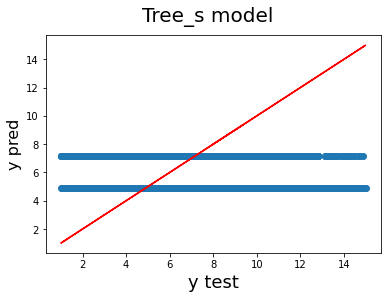

In [98]:
# Plotting tree y_test vs y_pred

fig = plt.figure()
plt.scatter(y_test, regr_tree_s.predict(X_test))
plt.plot(y_test,y_test,"r") # perfect model line
fig.suptitle('Tree_s model', fontsize = 20)
plt.xlabel('y test', fontsize = 18)
plt.ylabel('y pred', fontsize = 16)

Text(0, 0.5, 'y prediction')

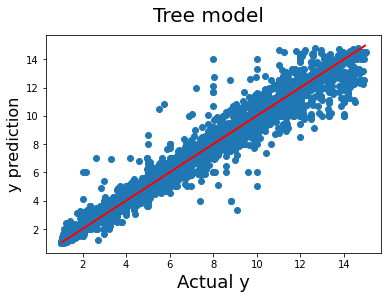

In [99]:
# Plotting tree y_test vs y_pred

fig = plt.figure()
plt.scatter(y_test, regr_tree.predict(X_test))
plt.plot(y_test,y_test,"r") # perfect model line
fig.suptitle('Tree model', fontsize = 20)
plt.xlabel('Actual y', fontsize = 18)
plt.ylabel('y prediction', fontsize = 16)

### Predictions using test data

In [100]:
# Predictions
lm = lm.predict(test)
lms = lms.predict(X_standardise_test)
ridge = ridge.predict(test)
ridge_s = ridge_s.predict(X_standardise_test)
lasso = lasso.predict(test)
lasso_s = lasso_s.predict(X_standardise_test)
tree = regr_tree.predict(test)
tree_s = regr_tree_s.predict(X_standardise_test)

In [101]:
tree

array([12.  , 12.02, 10.  ,  8.74,  7.67,  4.5 ,  3.64,  8.16,  8.23,
        9.29,  5.43,  6.  ,  8.81,  4.44,  4.44,  6.11,  8.  ,  4.44,
       10.28,  6.06,  6.11,  5.5 ,  6.09,  7.78,  5.56,  7.08,  9.48,
        7.61,  7.13,  7.93,  7.71,  6.  ,  9.65,  7.65,  4.87,  9.84,
       10.93, 11.11,  6.36,  6.11,  8.85,  7.98,  4.92,  6.39,  5.56,
        4.56,  5.  ,  5.16,  6.11,  4.37,  2.  ,  6.24,  6.24, 13.66,
        8.  ,  4.57, 12.  ,  8.96,  8.49,  6.  ,  9.29, 11.11,  6.03,
        8.91,  5.46,  6.47,  7.78,  4.51,  5.5 ,  7.1 ,  5.46,  4.67,
        2.9 ,  8.  ,  6.67,  4.79,  6.11,  9.58, 10.93,  6.56,  5.68,
        5.  ,  5.9 ,  5.56,  1.11,  6.19,  7.65, 12.13,  4.88,  6.54,
        9.37,  8.74,  8.03,  6.36,  6.  ,  7.25,  8.19,  8.74,  6.91,
        5.56,  9.98,  6.68,  6.  ,  7.65,  7.51,  8.47,  8.22,  2.73,
       10.  ,  5.  ,  5.08,  7.82,  6.12,  4.24,  6.76, 10.  ,  5.25,
        9.26,  4.44,  7.61,  5.95,  4.58,  9.97,  4.5 ,  8.17,  7.55,
        5.25,  9.58,

In [102]:
# ridge_s = np.round(ridge_s,2)

### Export csv

In [103]:
# create submission dataframe
# Create Dataframe of Order_No and Time from Pickup to Arrival
submission_lm = pd.DataFrame(
    {'Index': index,
     'avg_price_per_kg': lm
    })

submission_lms = pd.DataFrame(
    {'Index': index,
     'avg_price_per_kg': lms
    })

submission_lasso = pd.DataFrame(
    {'Index': index,
     'avg_price_per_kg': lasso
    })

submission_lasso_s = pd.DataFrame(
    {'Index': index,
     'avg_price_per_kg': lasso_s
    })

submission_ridge = pd.DataFrame(
    {'Index': index,
     'avg_price_per_kg': ridge
    })

submission_ridge_s = pd.DataFrame(
    {'Index': index,
     'avg_price_per_kg': ridge_s
    })

submission_tree = pd.DataFrame(
    {'Index': index,
     'avg_price_per_kg': tree
    })

submission_tree_s = pd.DataFrame(
    {'Index': index,
     'avg_price_per_kg': tree_s
    })

In [104]:
# save DataFrame to csv file for submission
submission_lm.to_csv("full set lm.csv", index=False)
submission_lms.to_csv("full set lms.csv", index=False)
submission_lasso.to_csv("full set lasso.csv", index=False)
submission_lasso_s.to_csv("full set lasso_s.csv", index=False)
submission_ridge.to_csv("full set ridge.csv", index=False)
submission_ridge_s.to_csv("full set ridge_s.csv", index=False)
submission_tree.to_csv("full set tree.csv", index=False)
submission_tree_s.to_csv("full set tree_s.csv", index=False)

## Saving a model with Pickle

In [105]:
import pickle

model_save_path = "tree_model.pkl"
with open(model_save_path,'wb') as file:
    pickle.dump(regr_tree,file)

In [106]:
X

,Weight_Kg,Sales_Total,Total_Qty_Sold
0,12.0,3236.0,29
1,18.3,51710.0,332
2,20.0,4860.0,66
3,9.0,600.0,10
4,10.0,41530.0,927
...,...,...,...
64371,10.0,19695.0,281
64372,18.0,13560.0,72
64373,3.5,6000.0,300
64374,10.0,16730.0,277


In [107]:
X['Weight_Kg'].max()

500.0

In [108]:
X.shape

(56890, 3)